In [1]:
#dacon_proj1: 퇴근시간 버스 승차인원 예측

'''
(train, test csv 공통사항)
해당 버스정류장에 대한 각각의 위도, 경도가 제공이 되어있는 상태로 같은 정류장 이름이지만 위도와 경도가 서로 다른 경우가 존재합니다.
해당 경우는, 같은 정류장 이름을 가지고 있는 길 건너편의 정류장에 해당이 됩니다.

train.csv 의 경우, 2019년 9월 제주도의 각 날짜, 출근시간(6시~12시)의 버스 정류장별 승하차 인원, 퇴근시간(18시~20시)의 버스 정류장별 승차 인원이 기록되어 있습니다.

bus_bts의 경우, 버스카드별로 승하차 정보가 기록이 되어있습니다. 해당 데이터는 탑승 시간대가오전 6시부터 12시 사이인 경우만 있습니다.

submission_제출양식의 경우, test data의 ID와 목표변수인 18시~20시 승차 인원로만 이루어져 있습니다.

추가 사용 가능 데이터

      a) (8회 kcb 시각화 대회의 제주도 금융라이프 데이터(jeju_financial_life_data.csv)

      b) 행정동별 위도 경도 데이터 https://dacon.io/?module=file&act=procFileDownload&file_srl=244977&sid=8cd192144ab18be0e02e4a16f851729b&module_srl=228539  (H - 행정동, B - 법정동)
'''

'\n(train, test csv 공통사항)\n해당 버스정류장에 대한 각각의 위도, 경도가 제공이 되어있는 상태로 같은 정류장 이름이지만 위도와 경도가 서로 다른 경우가 존재합니다.\n해당 경우는, 같은 정류장 이름을 가지고 있는 길 건너편의 정류장에 해당이 됩니다.\n\ntrain.csv 의 경우, 2019년 9월 제주도의 각 날짜, 출근시간(6시~12시)의 버스 정류장별 승하차 인원, 퇴근시간(18시~20시)의 버스 정류장별 승차 인원이 기록되어 있습니다.\n\nbus_bts의 경우, 버스카드별로 승하차 정보가 기록이 되어있습니다. 해당 데이터는 탑승 시간대가오전 6시부터 12시 사이인 경우만 있습니다.\n\nsubmission_제출양식의 경우, test data의 ID와 목표변수인 18시~20시 승차 인원로만 이루어져 있습니다.\n\n추가 사용 가능 데이터\n\n      a) (8회 kcb 시각화 대회의 제주도 금융라이프 데이터(jeju_financial_life_data.csv)\n\n      b) 행정동별 위도 경도 데이터 https://dacon.io/?module=file&act=procFileDownload&file_srl=244977&sid=8cd192144ab18be0e02e4a16f851729b&module_srl=228539  (H - 행정동, B - 법정동)\n'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,600 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120893 files and dire

In [4]:
cd /content/drive/MyDrive/Colab Notebooks/commit/Dacon

/content/drive/MyDrive/Colab Notebooks/commit/Dacon


In [5]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install scikit-learn
!pip install geopy
!pip install xgboost
!pip install lightgbm

#EDA

In [6]:
import numpy as np
import pandas as pd
import datetime

#결측값 유무
import missingno as msno

#빈도수 세기
from collections import Counter


In [7]:
train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/commit/Dacon/229255_bus_riders_at_rush_hour_data/train.csv')
test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/commit/Dacon/229255_bus_riders_at_rush_hour_data/test.csv')
bus_bts=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/commit/Dacon/229255_bus_riders_at_rush_hour_data/bus_bts.csv')

In [8]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
bus_bts.head()

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
0,1.010010e+15,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1
1,1.010010e+15,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1
2,1.019160e+15,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431.0,정존마을,4,1
3,1.019150e+15,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431.0,정존마을,1,1
4,1.010010e+15,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972.0,제주국제공항(종점),4,1


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             415423 non-null  int64  
 1   date           415423 non-null  object 
 2   bus_route_id   415423 non-null  int64  
 3   in_out         415423 non-null  object 
 4   station_code   415423 non-null  int64  
 5   station_name   415423 non-null  object 
 6   latitude       415423 non-null  float64
 7   longitude      415423 non-null  float64
 8   6~7_ride       415423 non-null  float64
 9   7~8_ride       415423 non-null  float64
 10  8~9_ride       415423 non-null  float64
 11  9~10_ride      415423 non-null  float64
 12  10~11_ride     415423 non-null  float64
 13  11~12_ride     415423 non-null  float64
 14  6~7_takeoff    415423 non-null  float64
 15  7~8_takeoff    415423 non-null  float64
 16  8~9_takeoff    415423 non-null  float64
 17  9~10_takeoff   415423 non-nul

In [11]:
bus_bts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2409414 entries, 0 to 2409413
Data columns (total 13 columns):
 #   Column               Dtype  
---  ------               -----  
 0   user_card_id         float64
 1   bus_route_id         int64  
 2   vhc_id               int64  
 3   geton_date           object 
 4   geton_time           object 
 5   geton_station_code   int64  
 6   geton_station_name   object 
 7   getoff_date          object 
 8   getoff_time          object 
 9   getoff_station_code  float64
 10  getoff_station_name  object 
 11  user_category        int64  
 12  user_count           int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 239.0+ MB


# 데이터 시각화를 통한 탐색적 데이터 분석

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# 내부에 결과를 출력하도록 설정
%matplotlib inline

# 시각화 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 마이너스 기호 출력
plt.rc('axes', unicode_minus=False)

# 분석에 문제가 없는 경고 메세지는 숨긴다.
import warnings
warnings.filterwarnings('ignore')

In [13]:
#지도 관련 시각화
import folium
from folium.plugins import MarkerCluster
import geopy.distance

#데이터 샘플링
import random
from sklearn.preprocessing import LabelEncoder #인코딩
from sklearn.preprocessing import OneHotEncoder

#validation
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

#model
import lightgbm as lgbm

#processing bar
from tqdm import tqdm_notebook

In [14]:
# 학습 데이터 복사본 생성
traindata = train.copy()

In [15]:
traindata.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<Axes: >

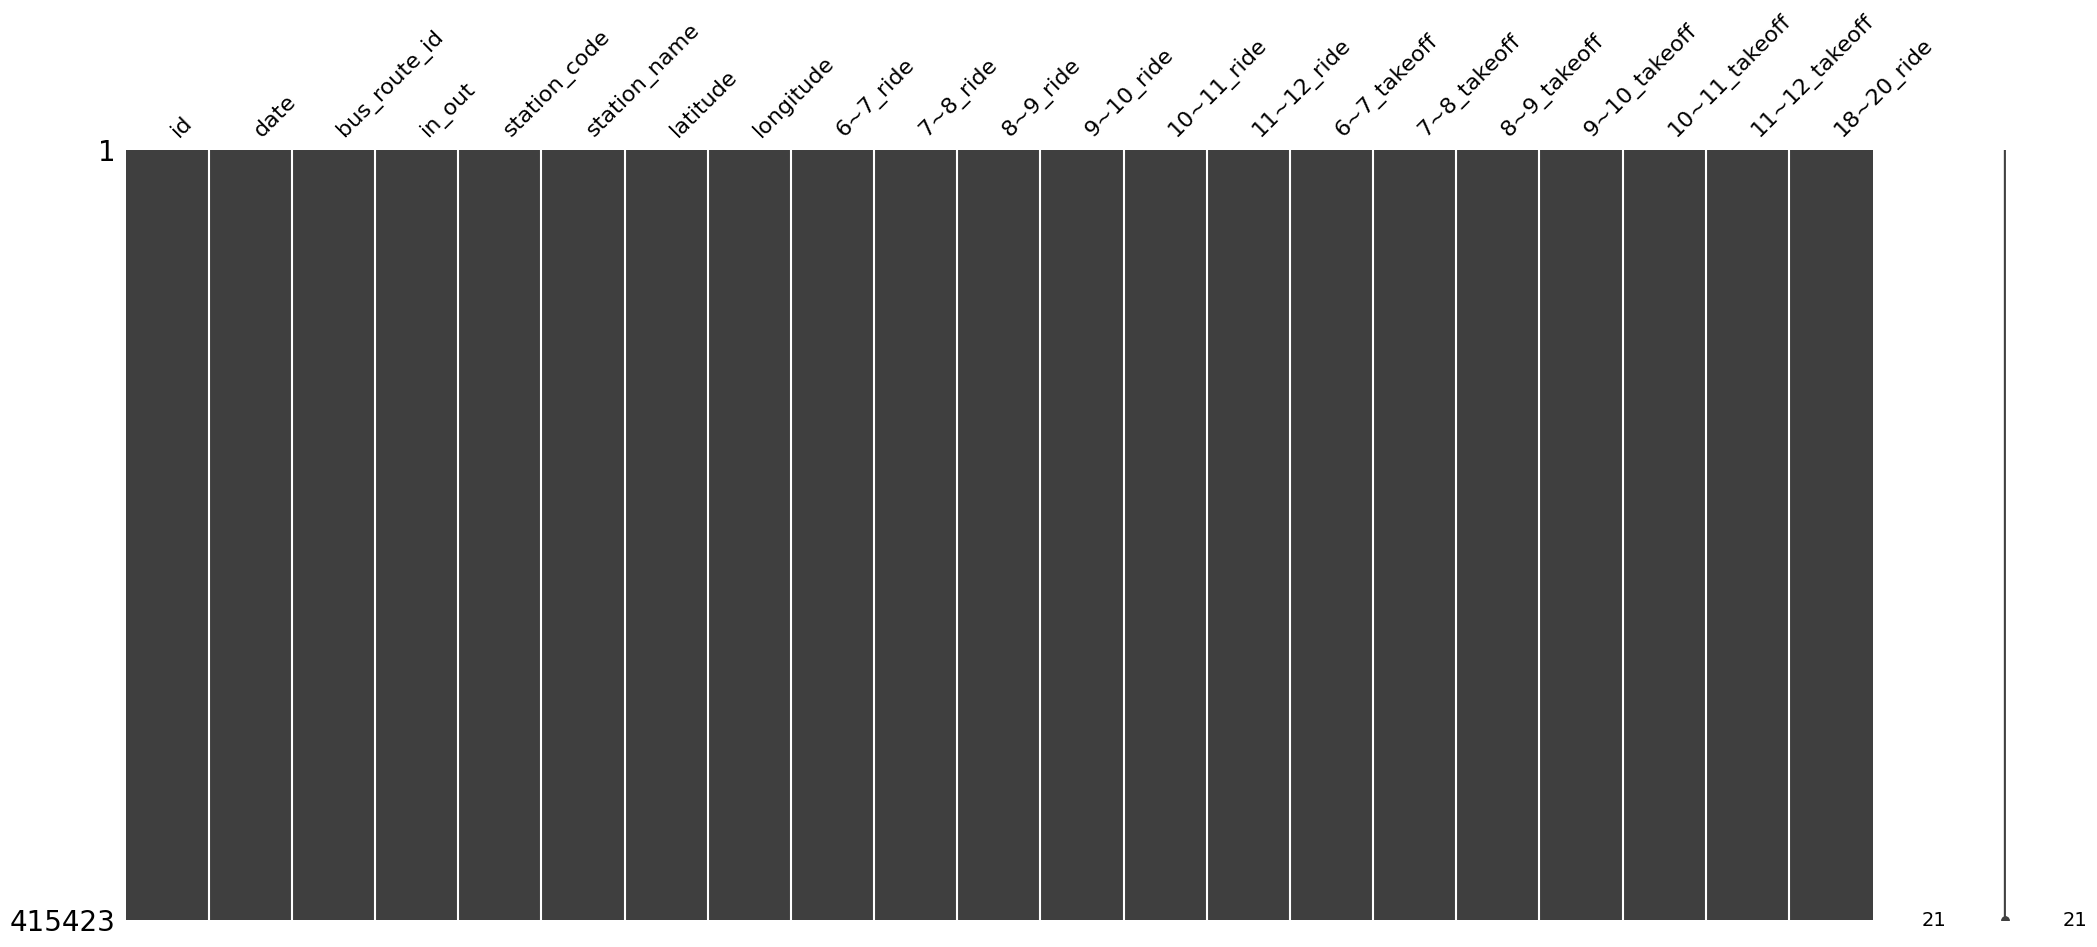

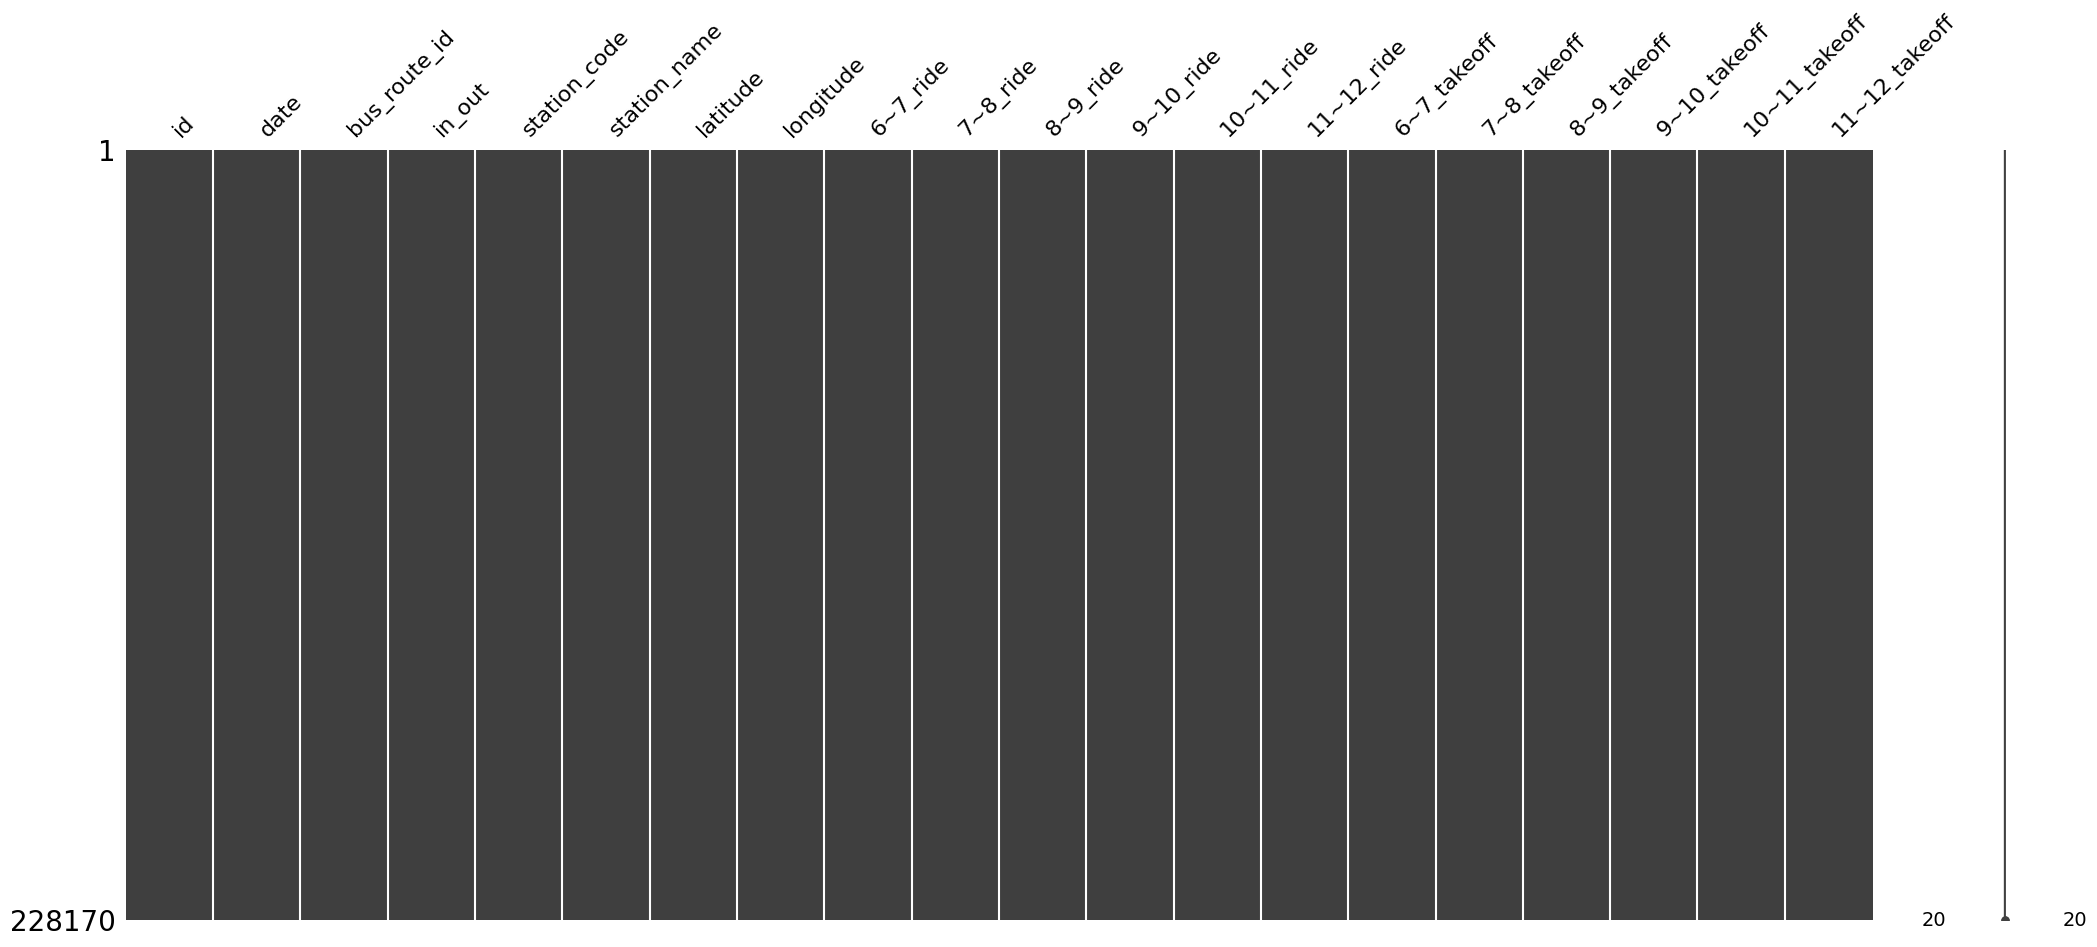

In [16]:
#결측값 확인-> 없다.
msno.matrix(train)
msno.matrix(test)

In [17]:
#다시 결측값 확인
print(train.isnull().sum())
print('-'*50)
print(test.isnull().sum())

id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
18~20_ride       0
dtype: int64
--------------------------------------------------
id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
dtype: int64


In [18]:
# train/test 날짜 범위 비교
train['date'].agg(['min','max'])
test['date'].agg(['min','max'])
#오호..날짜도 max,min 적용되는 구나.

min    2019-10-01
max    2019-10-16
Name: date, dtype: object

#타깃 변수(퇴근 시간 승차 인원) 분포 시각화
-> 타깃 부터 알아보는 것이 국룰..!?!


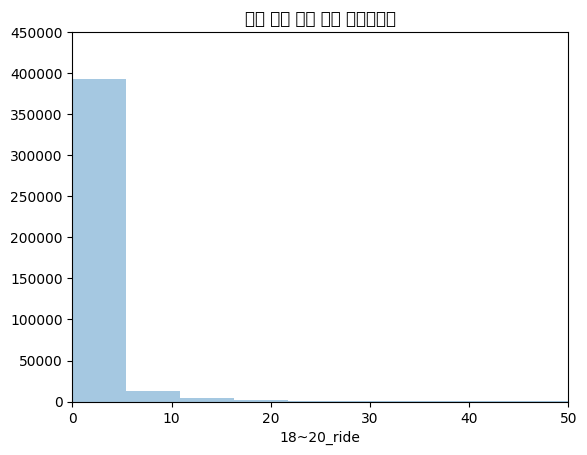

In [19]:
sns.distplot(traindata['18~20_ride'], kde = False, bins = 50)
plt.axis([0, 50, 0, 450000]) # [x 축 최솟값, x 축 최댓값, y 축 최솟값, y 축 최댓값]
plt.title("퇴근 시간 승차 인원 히스토그램")
plt.show()

In [20]:
# 타깃 변수(퇴근 시간 승차 인원) 분포 확인(수치)
target_col='18~20_ride'

traindata.groupby(target_col).size()

18~20_ride
0.0      296528
1.0       44268
2.0       23752
3.0       13560
4.0        8630
          ...  
240.0         1
241.0         1
245.0         1
265.0         1
272.0         1
Length: 170, dtype: int64

In [21]:
# 또는
traindata[target_col].value_counts().sort_index()

0.0      296528
1.0       44268
2.0       23752
3.0       13560
4.0        8630
          ...  
240.0         1
241.0         1
245.0         1
265.0         1
272.0         1
Name: 18~20_ride, Length: 170, dtype: int64

# Insight1
target인 18~20ride 분포가 대부분 0이다.

6-12시 내린 승객이 한명도 없고, 탄 승객이 없을 경우 해당 로우는 삭제

In [22]:
# 탑승 columns, 하차 columns
ride_columns = [col for col in test.columns if '_ride' in col]
take_off_columns = [col for col in test.columns if '_takeoff' in col]

# Train의 승차 칼럼들의 rowsum
display( train[train[target_col]==0][ride_columns].sum(axis=1).agg(['min','max']) )

# Train의 하차 칼럼들의 rowsum
display( train[train[target_col]==0][take_off_columns].sum(axis=1).agg(['min','max']) )

# Train의 승하차 합 칼럼들의 rowsum
display( train[train[target_col]==0][ride_columns + take_off_columns].sum(axis=1).agg(['min','max']) )

min      0.0
max    138.0
dtype: float64

min      0.0
max    165.0
dtype: float64

min      1.0
max    283.0
dtype: float64

In [23]:
#하나의 station name에 다수의 station_code 발견
multi_station=train.groupby('station_name')['station_code'].nunique().sort_values()
multi_station[multi_station>=2]
# multi_station

station_name
원동          2
토산관광지구입구    2
행장디         2
행원농공단지      2
토평반석타운      2
           ..
조수1리        5
비석거리        6
성읍1리        6
금악리         7
신안동         8
Name: station_code, Length: 1421, dtype: int64

In [24]:
multi_station.index

Index(['히귀반석', '제주자동차검사소', '제주은행', '보목신협', '보목신협앞', '보목입구', '보목포구(도착)',
       '보목포구(출발)', '제주웰컴센터', '보성리상동',
       ...
       '거로사거리', '청수리', '산방산', '산양리', '신시가지', '조수1리', '비석거리', '성읍1리', '금악리',
       '신안동'],
      dtype='object', name='station_name', length=1961)

In [25]:
train[train['station_name'].isin(multi_station.index)][['station_code', 'station_name', 'latitude', 'longitude']]

#결국, station_code가 고유값임을 확인. 고유 정류장 기준을 station_name으로 설정하기에는 어려움.

,station_code,station_name,latitude,longitude
0,344,제주썬호텔,33.48990,126.49373
1,357,한라병원,33.48944,126.48508
2,432,정존마을,33.48181,126.47352
3,1579,제주국제공항(600번),33.50577,126.49252
4,1646,중문관광단지입구,33.25579,126.41260
...,...,...,...,...
415418,1129,한림환승정류장(한림리),33.41437,126.26336
415419,1564,제주시외버스터미널,33.49946,126.51479
415420,2322,해병부대,33.23100,126.26273
415421,3291,애월환승정류장(애월리),33.46483,126.31870


In [26]:
train['station_code'].nunique(),train['station_name'].nunique()
#len(train['station_code'].unique()), len(train['station_name'].unique())
#하나의 station_name에 여러개의 station_code를 갖는구나.

(3563, 1961)

#Insight2
null값이 없으므로 정류장 코드, 정류장 좌표는 1:1 매핑<br>
정류장 이름-> 여러 정류장 코드o, 여러 정류장 좌표o

###결론: 정류장 이름은 대표성을 갖지 않음.
-> 정류장 이름이 유일하게 식별하는 데 적합x
즉, 정류장 이름만으로 정류장을 유일하게 식별하기 어려움. 코드나 좌표를 사용하여 정류장 식별해야 할 듯.

In [27]:
#요일 변수 생성

#날짜형으로 변환
traindata['date']=pd.to_datetime(traindata['date'])
#요일을 문자형으로 추출해 변수 생성
traindata['weekday']=traindata['date'].dt.strftime('%a')

In [28]:

traindata.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sun
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,Sun
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,Sun
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,Sun
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Sun


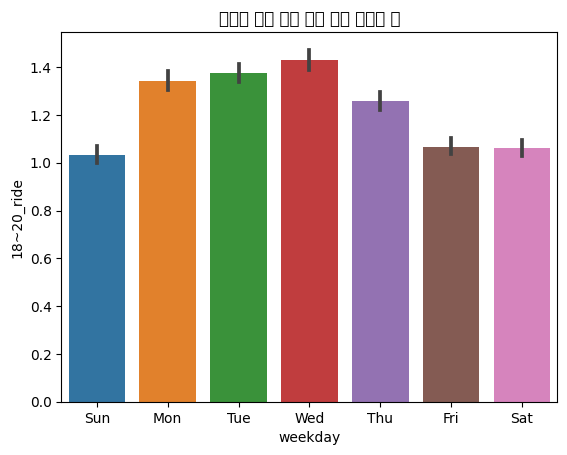

In [29]:
sns.barplot(x="weekday",y="18~20_ride",data=traindata)
plt.title('요일에 따른 퇴근 시간 평균 탑승객 수')
plt.show()

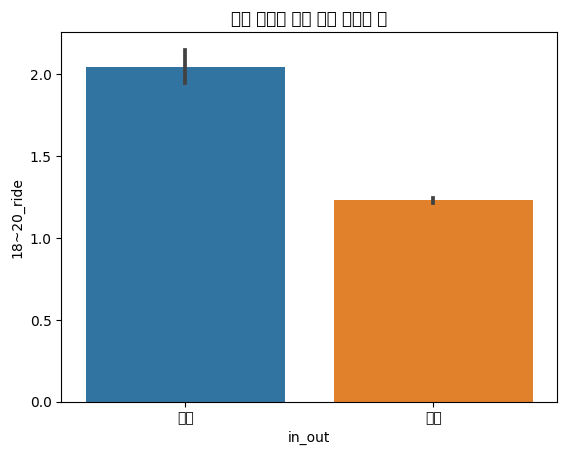

In [30]:
#버스 종류별 퇴근 시간 평균 탑승객 수 시각화
sns.barplot(x='in_out',y='18~20_ride',data=traindata)
plt.title('버스 종류에 따른 평균 탑승객 수')
plt.show()

In [31]:
#일별 출퇴근 시간의 총 승차 인원 데이터 생성
traindata['8~10_ride']=traindata['8~9_ride']+traindata['9~10_ride']

# 'weekday' 열을 Categorical 데이터 형식으로 변환하여 요일의 순서를 정의
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
eda_data=traindata.groupby('weekday')[['18~20_ride','8~10_ride']].agg('sum').reset_index()
eda_data['weekday'] = pd.Categorical(eda_data['weekday'], categories=weekday_order, ordered=True)

eda_data = eda_data.sort_values('weekday')

#상위 5개 행 확인
eda_data.head()

,weekday,18~20_ride,8~10_ride
1,Mon,104073.0,124448.0
5,Tue,87220.0,106168.0
6,Wed,88404.0,98547.0
4,Thu,74122.0,90351.0
0,Fri,59451.0,82103.0


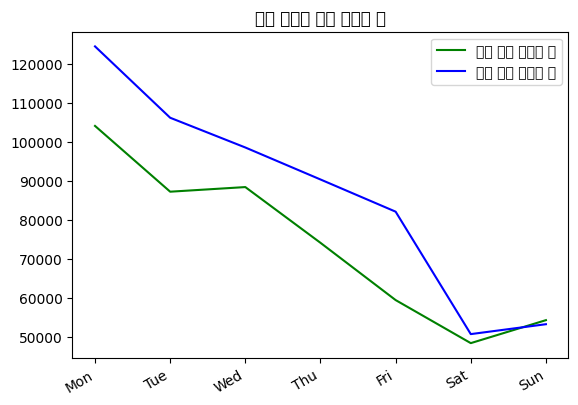

In [32]:
# 그룹화했으니 시각화 해서 봐야지._출퇴근 시간 탑승객 수 시각화
plt.plot('weekday','18~20_ride','g-',label='퇴근 시간 탑승객 수',data=eda_data)
plt.plot('weekday','8~10_ride','b-',label='출근 시간 탑승객 수', data=eda_data)
plt.gcf().autofmt_xdate() #x축의 라벨이 서로 겹치지 않도록 설정
plt.legend(loc=0) # 범례 표시
plt.title('일별 출퇴근 시간 탑승객 수')
plt.show()



#알 수 있었던 점
월요일이 가장 탑승횟수가 많고 점점 줄어듬.<br>
시외버스 탑승 횟수가 더 많음


In [33]:
ride_col_list=['%d~%d_ride'%(i,i+1) for i in range(6,12)]+[target_col]
takeoff_col_list=['%d~%d_takeoff'%(i,i+1) for i in range(6,12)]+[target_col]

In [34]:
df_date_ride=train.groupby(['date']).sum()[ride_col_list].stack().reset_index()
df_date_ride.columns=['date','ride_time','count']
df_date_ride['date_disp']=df_date_ride['date'].apply(lambda x:x[5:])

In [35]:
df_date_takeoff=train.groupby(['date']).sum()[takeoff_col_list].stack().reset_index()
df_date_takeoff.columns=['date','takeoff_time','count']
df_date_takeoff['date_disp']=df_date_takeoff['date'].apply(lambda x: x[5:])
df_date_takeoff.head(5)

,date,takeoff_time,count,date_disp
0,2019-09-01,6~7_takeoff,1343.0,09-01
1,2019-09-01,7~8_takeoff,2713.0,09-01
2,2019-09-01,8~9_takeoff,3671.0,09-01
3,2019-09-01,9~10_takeoff,4077.0,09-01
4,2019-09-01,10~11_takeoff,4510.0,09-01


<Axes: title={'center': '일별 하차량 증감'}, xlabel='date_disp', ylabel='count'>

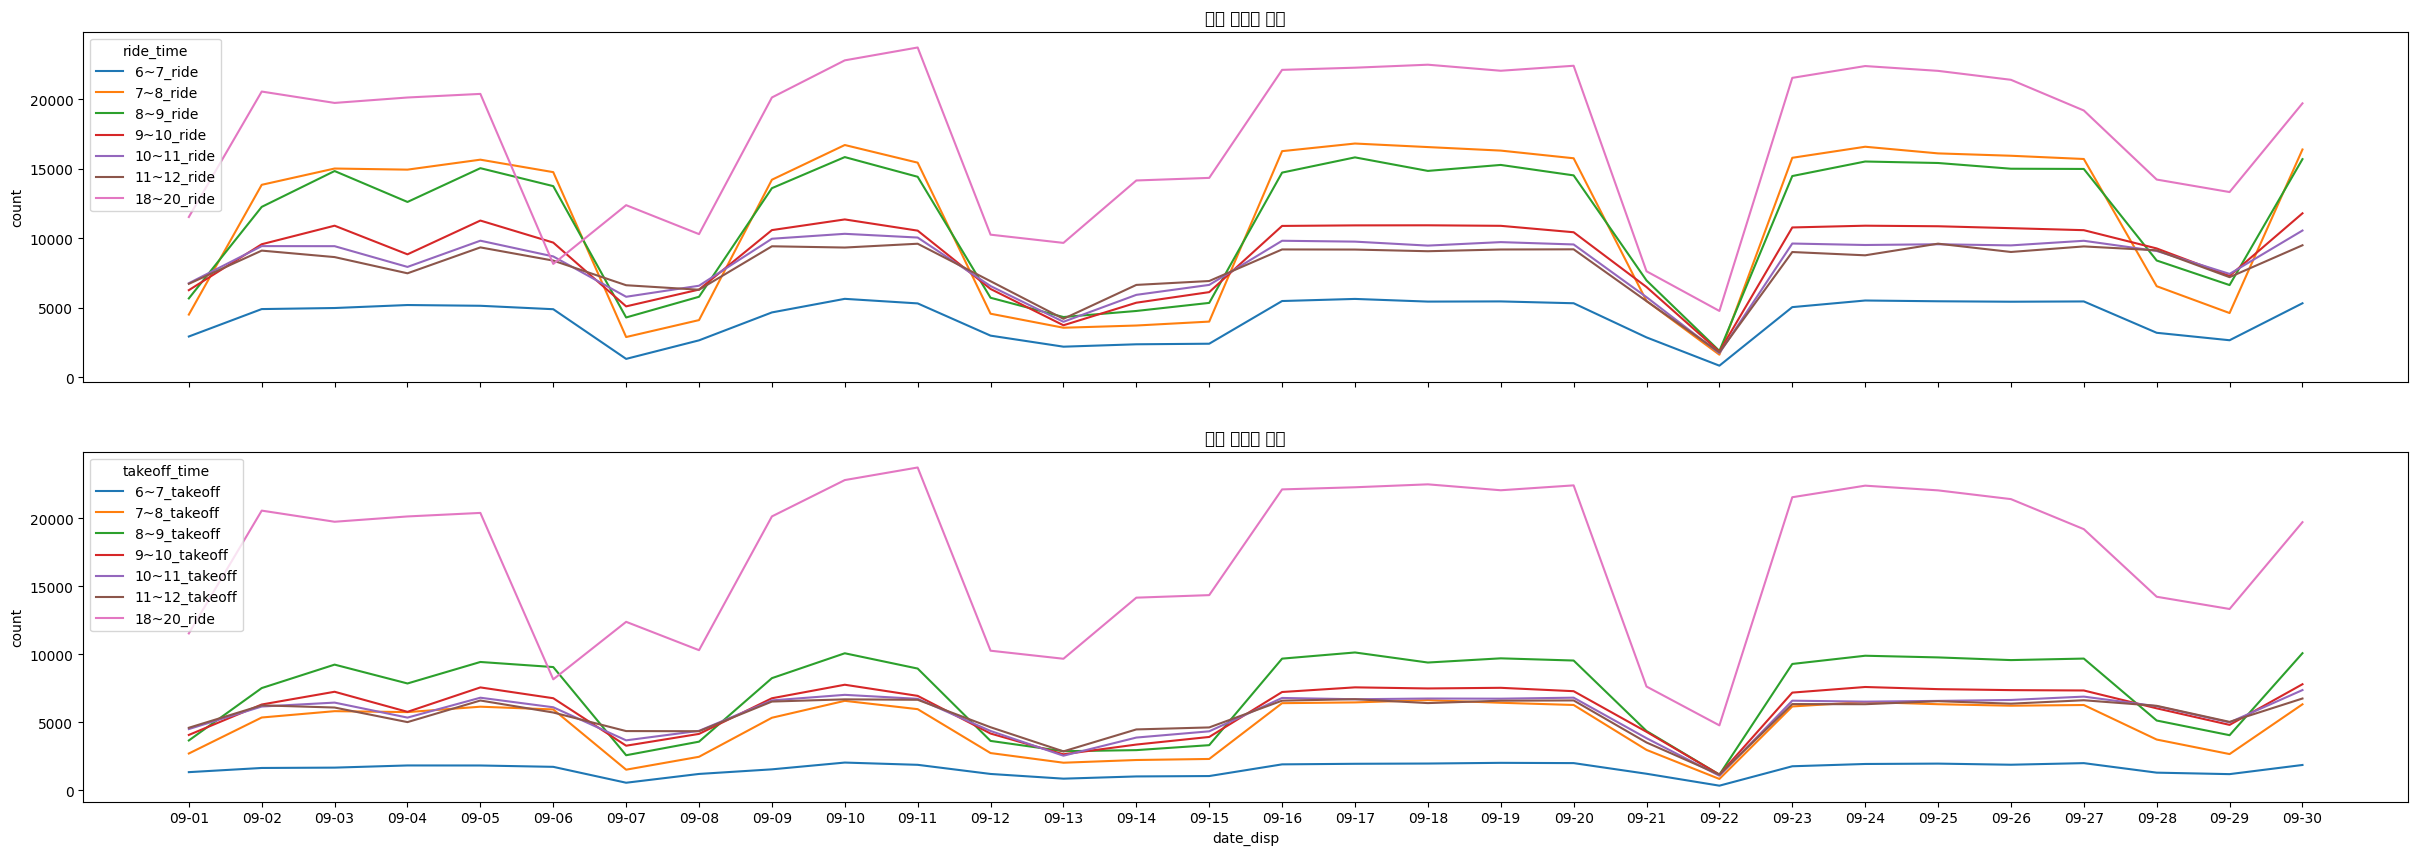

In [36]:
f,axes=plt.subplots(2,1,figsize=(30,10),sharex=True)

axes[0].set(title='일별 승차량 증감')
sns.lineplot(x='date_disp',y='count',hue='ride_time',data=df_date_ride, ax=axes[0])

axes[1].set(title='일별 하차량 증감')
sns.lineplot(x='date_disp',y='count',hue='takeoff_time',data=df_date_takeoff, ax=axes[1])

In [37]:
holidays = ['01-01', '02-04', '02-05', '02-06', '03-01', '05-05', '05-06', '05-12', '06-06', '08-15',
            '09-12', '09-13', '09-14', '10-03', '10-09', '12-25']
holidays = ['2019-'+day for day in holidays]

train['weekday'] = train['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%A"))
train['holiday'] = train.apply(lambda row: 'Y' if row.date in holidays else 'N', axis=1)
train['holiweekend'] = train.apply(lambda row: 'H' if row.holiday == 'Y' else 'N', axis=1)
train['holiweekend'] = train.apply(lambda row: 'WE' if row.holiweekend =='N' and row.weekday in ['Saturday', 'Sunday'] else row.holiweekend, axis=1)

In [38]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_week_ride = train.groupby(['weekday']).mean()[ride_col_list[:-1]].stack().reset_index()
df_week_ride.columns = ['weekday', 'ride_time', 'count']

df_week_takeoff = train.groupby(['weekday']).mean()[takeoff_col_list[:-1]].stack().reset_index()
df_week_takeoff.columns = ['weekday', 'takeoff_time', 'count']

df_week_ride['order'] = df_week_ride['weekday'].apply(lambda x: weekday_order.index(x))
df_week_ride=df_week_ride.sort_values(by=['order'])

df_week_takeoff['order'] = df_week_takeoff['weekday'].apply(lambda x: weekday_order.index(x))
df_week_takeoff=df_week_takeoff.sort_values(by=['order'])

<Axes: title={'center': '요일별 하차량 추이'}, xlabel='weekday', ylabel='count'>

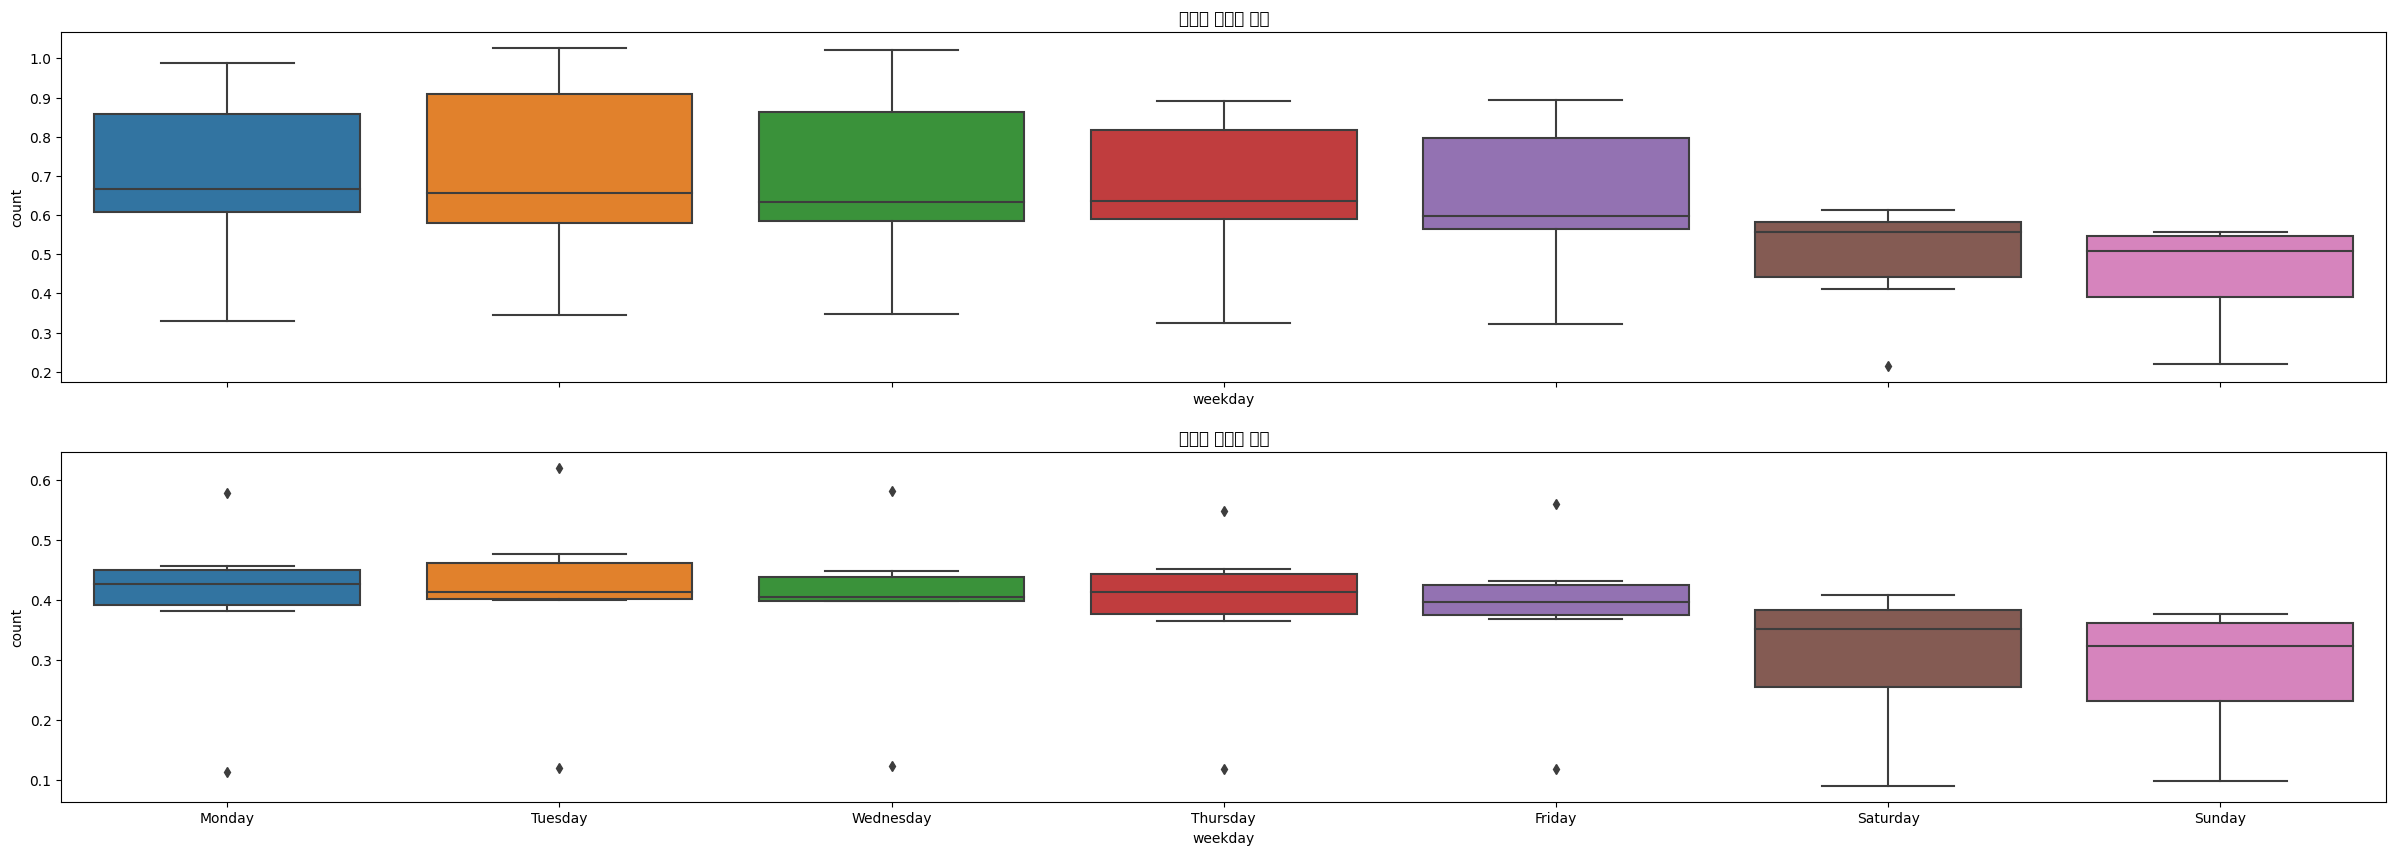

In [42]:
f, axes = plt.subplots(2, 1, figsize=(30, 10), sharex=True)


axes[0].set(title='요일별 승차량 추이')
axes[1].set(title='요일별 하차량 추이')

sns.boxplot(x='weekday', y='count', data=df_week_ride, ax=axes[0])
sns.boxplot(x='weekday', y='count', data=df_week_takeoff, ax=axes[1])

<Axes: xlabel='holiweekend', ylabel='count'>

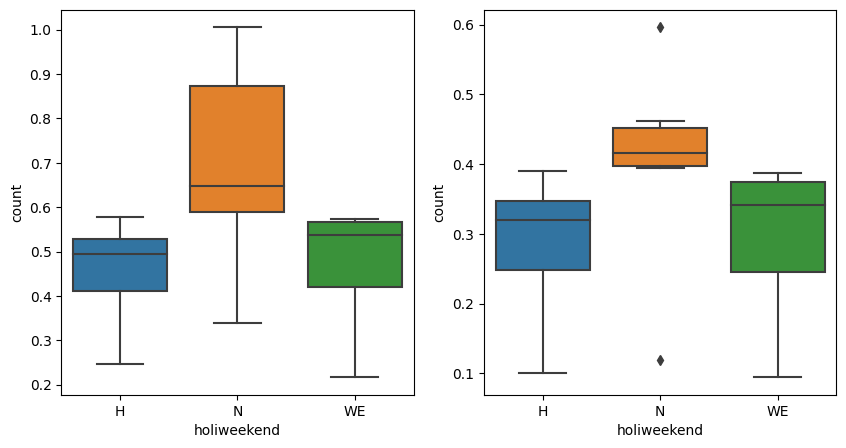

In [43]:
#평일, 휴일 승하차량 비교

f, axes = plt.subplots(1, 2, figsize=(10, 5))

df_holi_ride = train.groupby(['holiweekend']).mean()[ride_col_list[:-1]].stack().reset_index()
df_holi_ride.columns = ['holiweekend', 'ride_time', 'count']

df_holi_takeoff = train.groupby(['holiweekend']).mean()[takeoff_col_list[:-1]].stack().reset_index()
df_holi_takeoff.columns = ['holiweekend', 'ride_time', 'count']

sns.boxplot(x='holiweekend', y='count', data=df_holi_ride, ax=axes[0])
sns.boxplot(x='holiweekend', y='count', data=df_holi_takeoff, ax=axes[1])

#Insight3
7일 주기로 승하차량이 급감함. <br>
요일이 승하차량에 영향을 미치는 것-> 요일 파생변수 생성<br>
요일이 승하차량에 영향을 미친다면 공휴일도 영향을 미칠 것이라 추청-> 공휴일 정보 생성



In [44]:
#해당 주요 장소의 임의 지역 위도, 경도 (baseline)

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [45]:
#정류장의 위치만 확인하기-> groupby
data=train[['latitude','longitude','station_name']].drop_duplicates(keep='first')
data2=data.groupby(['station_name'])['latitude','longitude'].mean()
data2.to_csv('folium.csv')
data2=pd.read_csv('folium.csv')

In [46]:
data2

,station_name,latitude,longitude
0,(구)구판장,33.329705,126.797965
1,(구)중문동주민센터,33.251085,126.434300
2,(구)중앙파출소,33.247370,126.560713
3,(구)화산초등학교,33.326260,126.797250
4,1100고지휴게소,33.357820,126.463010
...,...,...,...
1956,흙통,33.262150,126.582590
1957,흥국사,33.452535,126.378260
1958,흥덕사,33.399080,126.876030
1959,희진주유소,33.377090,126.873840


In [48]:
#정류장의 대략적인 위치를 확인하여, folium map에 해당 정류장을 표시
for row in data2.itertuples():
  mc.add_child(folium.Marker(location=[row.latitude,  row.longitude],popup=row.station_name)) #마커 생성
  map_osm.add_child(mc) #마커를 map_osm에 추가

map_osm
